In [1]:
 # --------   Mounting the Drive to access the Data
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

Libraries

In [2]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 3.9 MB/s 


In [3]:
import os
import PIL
import cv2
import tarfile
import numpy as np
import pydicom
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib
import time
import random
from scipy import signal
from glob import glob
from PIL import Image
from scipy import ndimage as ndi
from skimage import data, morphology
from skimage.filters import threshold_multiotsu
from skimage.filters import rank,gaussian
from skimage.feature import peak_local_max
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.measure import label
from numpy.core.numeric import zeros_like

###Helper Functions

In [4]:
# --------   Contrast Enhancement - Histogram Stretching :
# Function to map each intensity level to output intensity level.
def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1)*pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2)/(255 - r2)) * (pix - r2) + s2

def contrastEnhance(Im):
  # Define parameters.
  r1 = 70
  s1 = 0
  r2 = 150
  s2 = 255
  # Vectorize the function to apply it to each value in the Numpy array.
  pixelVal_vec = np.vectorize(pixelVal)    
  # Apply contrast stretching.
  contrast_stretched = pixelVal_vec(Im, r1, s1, r2, s2)
  return contrast_stretched

In [5]:
def generate_id(number):
  num_str = str(number)
  l = len(num_str)
  id= ""
  for i in range(5-l):
    id = id +"0"

  id = id + num_str
  return id

#1. K-Means

Segmentation Function

In [6]:
def tumour_segment_k_means(Im):

  k=5
  attempts=10

  # Setting the font size for all plots.
  plt.rcParams['font.size'] = 9
  # The input image.
  image = contrastEnhance(Im)

  ## applying k means for k clusters
  img2=image.reshape((-1,1)) 

  img2=np.float32(img2)
  criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

  ret,label,center=cv2.kmeans(img2,k,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)

  center= np.uint8(center)#convert it into unsigned integer so that we can plot it
  res=center[label.flatten()] 

  res2=res.reshape((image.shape))

  #Normalization
  res2 = (res2 - np.min(res2))* (255 / (np.max(res2) - np.min(res2))) #sgementation from kmeans

  ret,thresh1 = cv2.threshold(res2,250,255,cv2.THRESH_BINARY)
  SE = [(0, 0, 1, 1, 1, 0, 0),
  (0, 1, 1, 1, 1, 1, 0),
  (1, 1, 1, 1, 1, 1, 1),
  (1, 1, 1, 1, 1, 1, 1),
  (1, 1, 1, 1, 1, 1, 1),
  (0, 1, 1, 1, 1, 1, 0),
  (0, 0, 1, 1, 1, 0, 0),]
   
  res = morphology.binary_opening(thresh1, SE)

  return res

#2. OTSU Thresholding & Mathematical Morphology

Segmentation Function

In [7]:
def segment_tumour_otsu_mm(image):
  # High pass filtering
  hp_filter = np.array([(-1, 2, -1), (0, 0, 0), (1, -2, 1)])
  f1 = signal.convolve2d(image, hp_filter, boundary='symm', mode='same')
  f1 = f1 + image
  f1 = f1.astype(np.float32)

  # Denoising (midean filter)
  f2 = signal.medfilt2d(f1)
  f2 = ((f2/np.max(f2))*255)
  f2 = f2.astype(int)

  #Multi-Otsu Thresholding

  thresholds = threshold_multiotsu(f2, classes=4)
  # Using the threshold values, we generate the regions.
  regions = np.digitize(f2, bins=thresholds)

  # Using the threshold values, we generate the regions.
  regions = np.digitize(f2, bins=thresholds)

  #Extracting the tumour region
  mask = regions==3
  mask = mask.astype(int)
 
  SE = [(0, 0, 1, 1, 1, 0, 0),
  (0, 1, 1, 1, 1, 1, 0),
  (1, 1, 1, 1, 1, 1, 1),
  (1, 1, 1, 1, 1, 1, 1),
  (1, 1, 1, 1, 1, 1, 1),
  (0, 1, 1, 1, 1, 1, 0),
  (0, 0, 1, 1, 1, 0, 0),]
   
  mask = morphology.binary_opening(mask, SE)
  return mask

#3. OTSU Thresholding & WATERSHED

Helper Functions

In [8]:
# --------   Function to get Markers
def get_markers(Im_, indices=False):
    im_ = gaussian(Im_, sigma=4)
    im_ = np.interp(im_, (im_.min(), im_.max()), (0, 1))
    grad = rank.gradient(im_[:,:],disk(5)).astype('int')
    
    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=7, exclude_border=True, indices=indices),grad

# --------   Function to get Descriptors :
def get_descr(region):
     return [region[:].mean()]       

Segmentation function

In [9]:
# --------   Define the Whole Function for 1 image :

def segment_tumour_otsu_ws(Image_):
  image = contrastEnhance(Image_)

  # ---------------------  MULTI OTSU  --------------------------------
  thresholds = threshold_multiotsu(image,5)
  regions = np.digitize(image, bins=thresholds)

  # -------  Mapping the Thresholded image's values to (0, 1)  -----------------
  Im_reg_ = np.interp(regions, (regions.min(), regions.max()), (0, 1))

  #  -----   WATERSHED  ----------
  markers, grad = get_markers(Im_reg_, False)   # Here indices=False as we don't need to show the markers
  markers = label(markers)
  ws = watershed(grad, markers)

  descriptors = np.zeros((ws.max()+1,1))
  im_descriptors = np.zeros_like(Im_reg_)  # Image with descriptors
  for i in range(ws.min(),ws.max()+1):
      descriptors[i] = get_descr(Im_reg_[ws==i])   # For each region, we get the mean value and put it to the image,
      im_descriptors[ws==i] = descriptors[i]

  # ---------------------  THRESHOLD  --------------------------------
  Seg_ = im_descriptors > (im_descriptors.max()-0.1) #(T+0.1)   # Keeping only the parts of the image that are bright enough in respect to the threshold T
  Seg__ = np.multiply(Seg_, 1)  # Converting Boolean to {0, 1}

  # ---------------------  Morphological Opening  --------------------------------
  SE = [[0, 0, 1, 1, 1, 0, 0],
      [0, 1, 1, 1, 1, 1, 0],
      [1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1],
      [0, 1, 1, 1, 1, 1, 0],
      [0, 0, 1, 1, 1, 0, 0]]
  Op = morphology.binary_opening(Seg__, SE) 

  return Op

# 4. Gaussian Mixture & EXPECTATION MAXIMIZATION

Helper Functions

In [10]:
# ------------------------   EM ALGORITHM - Functions  ---------------------
# https://github.com/iakovos777/EM-Algorithm-Image-Segmentation/blob/master/EM.py


# calculate f(e^f) in order to use logsumexp trick and avoid underflow/overflow
def f_logsumexp(x, mean, var, pi):
    N = x.shape[0]  # Number of pixels
    K = mean.shape[0]  # Number of clusters
    trick = np.zeros((N, K))
    for k in range(K):  # For each cluster 
        subtraction = np.subtract(x, mean[k])
        arg1 = -1.0 / (2 * var[k]) * np.power(subtraction, 2)
        arg2 = -0.5*np.log(2*np.pi*var[k])
        arg3 = np.sum(arg2 + arg1, axis=1)  # arg3 = sum[-0.5[((x-mu)²/var²) + log(2.pi.var²)]]
        arithmitis = np.log(pi[k]) + arg3  # log N(Xi| mu_i,var_i) the probability of observing a specific observation as a mixture
        trick[:, k] = arithmitis  # = log(pi) + sum[-0.5[((x-mu)²/var²) + log(2.pi.var²)]]
    # find max of all fk(trick[k]) for each example
    m = trick.max(axis=1)  # m = max(trick) = max(f)
    m = m.reshape((m.shape[0], 1))
    return trick, m


def update_gamma(f, m):  # Gamma = P_ic = [pi.N(Xi; mu_i,var_i)] / [sum(pi.N(Xi; mu_i,var_i))]
    f = f-m
    f = np.exp(f)   # f = exp(log(N(Xi| mu_i,var_i))) = N(Xi| mu_i,var_i)
    par = np.sum(f, axis=1)  # par = sum(N(Xi| mu_i,var_i))
    par = par.reshape((par.shape[0],1))
    result = np.divide(f, par)   
    return result


# return matrix with dimensions KxD
def update_mean(gamma, x):
    arith = np.dot(np.transpose(gamma), x)   # = transpose(P_ic).xi
    paran = np.sum(gamma, axis=0)  # sum(P_ic)
    paran = paran.reshape((paran.shape[0], 1))
    result = (arith/paran)+0.0001    # sum[transpose(P_ic).xi] / sum(P_ic)
    return result


# return vector with dimensions 1xK
def update_variance(gamma, x, mean):
    D = x.shape[1]
    K = mean.shape[0]
    arith = np.zeros((K, 1))
    for k in range(K):
        gamma_k = gamma[:, k]
        gamma_k = gamma_k.reshape((gamma_k.shape[0], 1))
        subtraction = np.subtract(x, mean[k])   # (xi-mu_i)
        # sub = sum[sum[P_ic.(xi-mu_i)²]]
        sub = np.sum(np.sum(np.multiply(np.power(subtraction, 2), gamma_k), axis=1))
        arith[k] = sub
    paran = D * np.sum(gamma, axis=0)   # = D.[sum[P_ic]
    paran = paran.reshape((K, 1))  
    return arith/paran   # var = sum[sum[P_ic.(xi-mu_i)²]] / D.[sum[P_ic]


def update_loglikehood(f, m):
    f = f - m   
    arg1 = np.sum(np.exp(f), axis=1)  
    arg1 = np.log(arg1)   # log(sum[exp(f-m)])
    arg1 = arg1.reshape((arg1.shape[0], 1))
    arg2 = arg1+m  
    return np.sum(arg2, axis=0)  # L = sum[m + log(sum[exp(f-m)])]


def init_parameters(D, K):
    mean = np.random.rand(K, D)
    var = np.random.uniform(low=0.1, high=1, size=K)    
    val = 1/K  # Equiprobability
    pi = np.full(K, val)  
    return mean, var, pi


# pi is not np.pi = 3.14.... It's a different variable
def EM(x, K, tol):
    # counter in order to count iterations and stop after some in order our program doesn't run for an eternity
    counter = 1
    # num of examples(Here pixels)
    N = x.shape[0]
    # num of dimensions of each examples(Here Grayscal = 1 canal)
    D = x.shape[1]
    # init parameters
    mean, var, pi = init_parameters(D, K)
    # logsumexp trick
    f, m = f_logsumexp(x, mean, var, pi)
    loglikehood = update_loglikehood(f, m)
    while counter <= 100:
        # --  E-step
        gamma = update_gamma(f, m)  

        # --  M-step
        # update pi
        pi = (np.sum(gamma, axis=0))/N
        # update mean
        mean = update_mean(gamma, x)
        # update variance(var)
        var = update_variance(gamma, x, mean)
        old_loglikehood = loglikehood
        # logsumexp trick
        f, m = f_logsumexp(x, mean, var, pi)
        loglikehood = update_loglikehood(f, m)
        # check if algorithm is correct
        if loglikehood-old_loglikehood < 0:
            # print('Error found in EM algorithm')
            # print('Number of iterations: ', counter)
            exit()
        # check if the convergence criterion is met
        if abs(loglikehood-old_loglikehood) < tol:
            # print('Convergence criterion is met')
            # print('Total iterations: ', counter)
            return mean, gamma
        # update 'safety valve' in order to not loop for an eternity
        counter += 1
    return mean, gamma


def error_reconstruction(x, means_of_data):  # Compute Mean Square Error
    N = x.shape[0]
    x = x*255  # Normalize to [0:255]
    x = x.astype(np.uint8)
    diff = x-means_of_data
    sum1 = np.sqrt(np.sum(np.power(diff, 2)))  # = sqrt(sum[x - mean]²)
    error = sum1/N  # error = sqrt(sum[x - mean]²) / N
    return error


def reconstruct_image(x, mean, gamma, K, height, width):
    D = mean.shape[1]
    # denormalize values
    mean = mean * 255
    # set data-type uint8 so every data is in set [0,255]
    mean = mean.astype(np.uint8)
    max_likelihood = np.argmax(gamma, axis=1)  # 1xN
    # matrix that has for each example(pixel) the means of dimensions(R,G,B) of k(=cluster) with highest
    # a  posteriori probability gamma. This matrix is our new data(pixels)
    means_of_data = np.array([mean[i] for i in max_likelihood])  # NxD
    # set data-type uint8 so every data is in set [0,255]
    means_of_data = means_of_data.astype(np.uint8)
    # calculate error
    error = error_reconstruction(x, means_of_data)
    # print('Error of reconstruction:', error)
    means_of_data = means_of_data.reshape((height, width, D))
    #segmented_image = Image.fromarray(means_of_data) #, mode='RGB')
    #print(means_of_data.shape)
    #plt.imshow(means_of_data[:,:,0], cmap="bone")
    # name = 'Segmented_Images\segmented_image_'+str(K)+'.jpg'
    # segmented_image.save(name)
    return means_of_data


def run(x, K, tol, height, width):
    #for K in cluster:
        # print('------ Cluster: '+str(K)+' ------')
        start_time = time.time()
        mean, gamma = EM(x, K, tol)
        end_time = time.time()
        em_time = end_time-start_time
        # print("Time of execution of EM for clusters/k = %s  is %s seconds " % (K, em_time))
        Im = reconstruct_image(x, mean, gamma, K, height, width) ##### !!!!!!!!
        return Im

Segmentation Function

In [11]:
def segment_tumour_gm_em(Im):
  Im = contrastEnhance(Im)
  tolerance = 1e-3
  clusters = 5 
  # load image as pixel array
  data = np.asarray(Im)
  # summarize shape of the pixel array
  (height, width) = data.shape
  max_value = np.amax(data)
  D = 1 # D = dimensions of each data (Here R,G,B)
  dataset = data.reshape((height*width, D))    # N = number of data set (Here height*width of image)  
  # normalize data
  dataset = dataset/max_value
  I = run(dataset, clusters, tolerance, height, width)  # Excecute the function 

  image = I[:,:,0]/255
  Seg_ = image > (image.max()-0.1)   # Keeping only the parts of the image that are bright enough in respect to the threshold T
  Seg__ = np.multiply(Seg_, 1)  # Converting Boolean to {0, 1}
  
  # Opening :
  SE = [[0, 0, 1, 1, 1, 0, 0],
      [0, 1, 1, 1, 1, 1, 0],
      [1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1],
      [0, 1, 1, 1, 1, 1, 0],
      [0, 0, 1, 1, 1, 0, 0]]
  Op = morphology.binary_opening(Seg__, SE)   
  return Op

# 5. Comparison

###Evaluation metrics

In [27]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

In [28]:
def sensitivity (seg,ground): 
    #computs true positive rate
    num=np.sum(np.multiply(ground, seg ))
    denom=np.sum(ground)
    if denom==0:
        return 1
    else:
        return  num/denom

In [29]:
def specificity (seg,ground): 
    #computes true negative rate
    num=np.sum(np.multiply(ground==0, seg ==0))
    denom=np.sum(ground==0)
    if denom==0:
        return 1
    else:
        return  num/denom

## Qualitative comparaison

### - For 1 Image:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  import sys


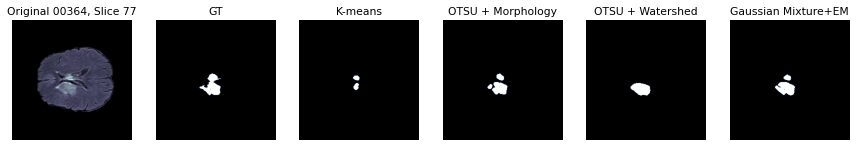

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 4))
img_id = "00364" 
j = 77
for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_flair.nii.gz']):
  try:
    image = nib.load(nii).get_fdata()
  except FileNotFoundError:
    print(f'Image {img_id} does not exist')
    continue
  curr_im = image[:, :, j]*255/(((image[:, :, j]).max()))
  km_seg = tumour_segment_k_means(curr_im)
  otsu_mm_seg = segment_tumour_otsu_mm(curr_im)
  otsu_ws_seg = segment_tumour_otsu_ws(curr_im)
  gm_em_seg = segment_tumour_gm_em(curr_im)
  # Plotting the original image
  ax[0].imshow(curr_im, cmap='bone')
  ax[0].set_title(f'Original {img_id}, Slice {j}')
  ax[0].axis('off')
  # Plotting the segmentation result
  # K-means
  ax[2].imshow(km_seg, cmap='bone')
  ax[2].set_title('K-means')
  ax[2].axis('off')
  # OTSU+Morphology
  ax[3].imshow(otsu_mm_seg, cmap='bone')
  ax[3].set_title('OTSU + Morphology')
  ax[3].axis('off')
  # OTSU+Watershed
  ax[4].imshow(otsu_ws_seg, cmap='bone')
  ax[4].set_title('OTSU + Watershed')
  ax[4].axis('off')
  # Gaussian Mixture+EM
  ax[5].imshow(gm_em_seg, cmap='bone')
  ax[5].set_title('Gaussian Mixture+EM')
  ax[5].axis('off')

for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_seg.nii.gz']):
  try:
    gt = nib.load(nii).get_fdata()
  except FileNotFoundError:
    print(f'Image {img_id} does not exist')
    continue
  gt = gt[:, :, j]
  gt = gt>0
  gt = gt.astype(int)
  ax[1].imshow(gt, cmap='bone')
  ax[1].set_title('GT')
  ax[1].axis('off')

plt.subplots_adjust()
plt.show()

In [33]:
methods = ["K-Means", "Multi-Otsu", "Watershed", "GMM/EM"]
seg = [km_seg, otsu_mm_seg, otsu_ws_seg, gm_em_seg]



for i in range(4):
  dice = dice_coef2(gt, seg[i])
  sens = sensitivity(seg[i], gt)
  spec = specificity(seg[i], gt)
  print(f'*********{methods[i]}*********')
  print(f'Dice = {dice}')
  print(f'Sensitivity = {sens}')
  print(f'Specificity = {spec}')

*********K-Means*********
Dice = 0.3717277486910995
Sensitivity = 0.2282958199356913
Specificity = 1.0
*********Multi-Otsu*********
Dice = 0.864338866628506
Sensitivity = 0.8092175777063236
Specificity = 0.9989588296539432
*********Watershed*********
Dice = 0.7434052757793765
Sensitivity = 0.6645230439442658
Specificity = 0.9979706001729401
*********GMM/EM*********
Dice = 0.8656387665198237
Sensitivity = 0.842443729903537
Specificity = 0.9982882453632625


###- For Multiple images

In [ ]:
samples = [100, 150, 132, 250, 485, 569, 784, 799, 807, 836, 636]
for i in samples:
  j = random.sample(range(5, 150),1)
  j = j[0]
  fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 4))
  img_id = "00" + str(i)
  for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_flair.nii.gz']):
      try:
        image = nib.load(nii).get_fdata()
      except FileNotFoundError:
        print(f'Image {img_id} does not exist')
        continue
      curr_im = image[:, :, j]*255/(((image[:, :, j]).max()))
      km_seg = tumour_segment_k_means(curr_im)
      otsu_mm_seg = segment_tumour_otsu_mm(curr_im)
      otsu_ws_seg = segment_tumour_otsu_ws(curr_im)
      gm_em_seg = segment_tumour_gm_em(curr_im)
      # Plotting the original image
      ax[0].imshow(curr_im, cmap='bone')
      ax[0].set_title(f'Original {img_id}, Slice {j}')
      ax[0].axis('off')
      # Plotting the segmentation result
      # K-means
      ax[2].imshow(km_seg, cmap='bone')
      ax[2].set_title('K-means')
      ax[2].axis('off')
      # OTSU+Morphology
      ax[3].imshow(otsu_mm_seg, cmap='bone')
      ax[3].set_title('OTSU + Morphology')
      ax[3].axis('off')
      # OTSU+Watershed
      ax[4].imshow(otsu_ws_seg, cmap='bone')
      ax[4].set_title('OTSU + Watershed')
      ax[4].axis('off')
      # Gaussian Mixture+EM
      ax[5].imshow(gm_em_seg, cmap='bone')
      ax[5].set_title('Gaussian Mixture+EM')
      ax[5].axis('off')

  for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_seg.nii.gz']):
      try:
        gt = nib.load(nii).get_fdata()
      except FileNotFoundError:
        print(f'Image {img_id} does not exist')
        continue
      gt = gt[:, :, j]
      gt = gt>0
      gt = gt.astype(int)
      ax[1].imshow(gt, cmap='bone')
      ax[1].set_title('GT')
      ax[1].axis('off')

  plt.subplots_adjust()
  plt.show()

## Quantitative Testing

In [ ]:
# Create Data Directory
if not os.path.isdir("/content/drive/MyDrive/BRATS/Data"):
    os.makedirs("/content/drive/MyDrive/BRATS/Data", exist_ok=True)
    
# Load Competition Training Dataframe
train_df = pd.read_csv("/content/drive/MyDrive/BRATS/train.csv")
print(len(train_df))


577


In [ ]:
samples = random.sample(range(0, 100), 10) #choose random images
js = random.sample(range(5, 150), 30) #choose random slices

print(samples)
print(js)

[21, 50, 37, 61, 69, 79, 84, 94, 57, 36]
[82, 103, 100, 118, 130, 122, 79, 139, 51, 6, 142, 76, 17, 86, 115, 65, 72, 63, 149, 43, 30, 144, 94, 145, 22, 25, 23, 8, 41, 47]


In [ ]:
# samples = [41, 42, 8, 12, 89, 70, 65, 35, 30, 1]
# js = [75, 21, 48, 54, 7, 91, 37, 124, 73, 98, 140, 24, 112, 111, 52, 93, 131, 35, 82, 43, 33, 121, 95, 67, 149, 102, 5, 81, 11, 41]

In [ ]:
x = 0 # number of slices processed counter
km_dice = 0
otsu_mm_dice =0
otsu_ws_dice = 0
gm_em_dice = 0

km_sen = 0
otsu_mm_sen =0
otsu_ws_sen = 0
gm_em_sen = 0

km_spec = 0
otsu_mm_spec =0
otsu_ws_spec = 0
gm_em_spec = 0

# samples = random.sample(range(0, 100), 10) #choose random images
# js = random.sample(range(10, 140), 20) #choose random slices
for i in samples:
  im_id = train_df.loc[i,'BraTS21ID']
  print(f'i={i}, im_id={im_id}')
  img_id = generate_id(im_id) #generate ID
  # Loading the Ground Truth
  for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_seg.nii.gz']):
    try:
      gt_t = nib.load(nii).get_fdata() #total GT
    except FileNotFoundError:
      print(f'Image {img_id} does not exist')
      continue
  # Segmenting the chosen slices
  for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_flair.nii.gz']):
    try:
      image = nib.load(nii).get_fdata()
    except FileNotFoundError:
      print(f'Image {img_id} does not exist')
      continue
    for j in js:
      print(f'Image {img_id} slice {j}')
      if((image[:, :, j]).max()!=0):
        curr_im = image[:, :, j]*255/((image[:, :, j]).max())
      gt = gt_t[:, :, j]
      try:
        km_seg = tumour_segment_k_means(curr_im)
        otsu_mm_seg = segment_tumour_otsu_mm(curr_im)
        otsu_ws_seg = segment_tumour_otsu_ws(curr_im)
        gm_em_seg = segment_tumour_gm_em(curr_im)
      except ValueError:
        continue

      # Dice Score 
      d_km = dice_coef2(gt, km_seg)
      d_otsu_mm = dice_coef2(gt, otsu_mm_seg)
      d_otsu_ws = dice_coef2(gt, otsu_ws_seg)
      d_gm_em = dice_coef2(gt, gm_em_seg)
  
      km_dice += d_km 
      otsu_mm_dice += d_otsu_mm
      otsu_ws_dice += d_otsu_ws
      gm_em_dice += d_gm_em

      # Specificity
      spec_km = specificity(km_seg, gt)
      spec_otsu_mm = specificity(otsu_mm_seg, gt)
      spec_otsu_ws = specificity(otsu_ws_seg, gt)
      spec_gm_em = specificity(gm_em_seg, gt)

      km_spec += spec_km 
      otsu_mm_spec += spec_otsu_mm
      otsu_ws_spec += spec_otsu_ws
      gm_em_spec += spec_gm_em

      #Sensitivity
      sen_km = sensitivity(km_seg, gt)
      sen_otsu_mm = sensitivity(otsu_mm_seg, gt)
      sen_otsu_ws = sensitivity(otsu_ws_seg, gt)
      sen_gm_em = sensitivity(gm_em_seg, gt)

      km_sen += sen_km 
      otsu_mm_sen += sen_otsu_mm
      otsu_ws_sen += sen_otsu_ws
      gm_em_sen += sen_gm_em
      x += 1
print(f'x={x}')
#Dice
dice_avg_km = km_dice/x
dice_avg_otsu_mm = otsu_mm_dice/x
dice_avg_otsu_ws = otsu_ws_dice/x
dice_avg_gm_em = gm_em_dice/x

#Specificity
spec_avg_km = km_spec/x
spec_avg_otsu_mm = otsu_mm_spec/x
spec_avg_otsu_ws = otsu_ws_spec/x
spec_avg_gm_em = gm_em_spec/x

#Sensitivity
sen_avg_km = km_sen/x
sen_avg_otsu_mm = otsu_mm_sen/x
sen_avg_otsu_ws = otsu_ws_sen/x
sen_avg_gm_em = gm_em_sen/x


#Results
print('************ Average Dice Score ***************')
print(f'K-means = {dice_avg_km}')
print(f'OTSU + Mathematical Morphology = {dice_avg_otsu_mm}')
print(f'OTSU + Watershed = {dice_avg_otsu_ws}')
print(f'Gaussian Mixture end EM= {dice_avg_gm_em}')

print('************ Average Specificity ***************')
print(f'K-means = {spec_avg_km}')
print(f'OTSU + Mathematical Morphology = {spec_avg_otsu_mm}')
print(f'OTSU + Watershed = {spec_avg_otsu_ws}')
print(f'Gaussian Mixture end EM= {spec_avg_gm_em}')

print('************ Average Sensitivity ***************')
print(f'K-means = {sen_avg_km}')
print(f'OTSU + Mathematical Morphology = {sen_avg_otsu_mm}')
print(f'OTSU + Watershed = {sen_avg_otsu_ws}')
print(f'Gaussian Mixture end EM= {sen_avg_gm_em}')



# Test on an image

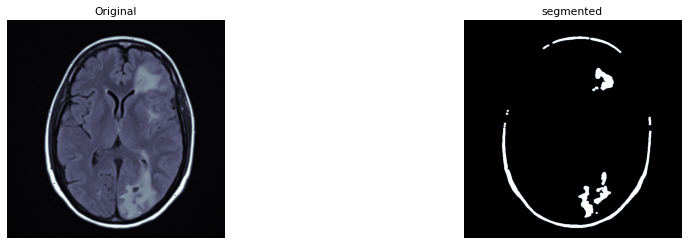

In [ ]:
from PIL import Image, ImageOps

#Import image
image = Image.open('brain.jpeg')
image = ImageOps.grayscale(image)
image = np.asarray(image)

#segment image
seg = tumour_segment_k_means(image)
#plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))


ax[0].imshow(image, cmap='bone')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(seg, cmap='bone')
ax[1].set_title('segmented')
ax[1].axis('off')

plt.subplots_adjust()
plt.show()